# Task 1: Introduction

---

For this project, we are going to work on evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude

![Regression](images/regression.png)

Note: This notebook uses `python 3` and these packages: `tensorflow`, `pandas`, `matplotlib`, `scikit-learn`.

## 1.1: Importing Libraries & Helper Functions

First of all, we will need to import some libraries and helper functions. This includes TensorFlow and some utility functions that I've written to save time.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline
# tf.logging.set_verbosity(tf.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print('Libraries imported.')

Libraries imported.


# Task 2: Importing the Data

## 2.1: Importing the Data

The dataset is saved in a `data.csv` file. We will use `pandas` to take a look at some of the rows.

In [3]:
df = pd.read_csv('data.csv', names = column_names) 
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


## 2.2: Check Missing Data

It's a good practice to check if the data has any missing values. In real world data, this is quite common and must be taken care of before any data pre-processing or model training.

In [4]:
df.isna().sum()

# Checking the number of NaN values in the whole dataset

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

# Task 3: Data Normalization

## 3.1: Data Normalization

We can make it easier for optimization algorithms to find minimas by normalizing the data before training a model.

In [5]:
df = df.iloc[:,1:]
df_norm = (df - df.mean()) / df.std()
# This is normalisation

# We do not use standardisation here because we want a specific set of values in between 0 and 1
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


## 3.2: Convert Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [6]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    return int(pred * y_std + y_mean)    #This step is for the conversion of normalised value of price to the original price during plotting

print(convert_label_value(0.350088))

14263


# Task 4: Create Training and Test Sets

## 4.1: Select Features

Make sure to remove the column __price__ from the list of features as it is the label and should not be used as a feature.

In [7]:
X = df_norm.iloc[:, :6]
X.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


## 4.2: Select Labels

In [8]:
Y = df_norm.iloc[:, -1]
Y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

## 4.3: Feature and Label Values

We will need to extract just the numeric values for the features and labels as the TensorFlow model will expect just numeric values as input.

In [9]:
X_arr = X.values
Y_arr = Y.values

print('X_arr shape: ', X_arr.shape)
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (5000, 6)
Y_arr shape:  (5000,)


## 4.4: Train and Test Split

We will keep some part of the data aside as a __test__ set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states. This way, we can make sure that we are going in the right direction with our model training.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.05, shuffle = True, random_state=0)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4750, 6)
y_train shape:  (4750,)
X_test shape:  (250, 6)
y_test shape:  (250,)


# Task 5: Create the Model

## 5.1: Create the Model

Let's write a function that returns an untrained model of a certain architecture.

In [11]:
def get_model():
    
    model = Sequential([
        Dense(10, input_shape = (6,), activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(5, activation = 'relu'),
        Dense(1)
    ])
#     Making the model

    model.compile(
        loss='mse',
        optimizer='adadelta'
    )
    
#     Specifying the loss functions and the optimiser
    
    return model

model = get_model()
model.summary()
# Summary method gives the details of the number of parameters involved in the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                70        
                                                                 
 dense_1 (Dense)             (None, 20)                220       
                                                                 
 dense_2 (Dense)             (None, 5)                 105       
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


# Task 6: Model Training

## 6.1: Model Training

We can use an `EarlyStopping` callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs.

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)
# If the validation loss still does not decrease even after 5 times repetition, then the operation will be stopped

model = get_model()

preds_on_untrained = model.predict(X_test)
# Predicting on untrained model for comparison purposes

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 1000,
    callbacks = [early_stopping]
)

# In this history object we store the model output after fitting the model or rather training

8/8 [==============================] - 2s 7ms/step
Epoch 1/1000
149/149 [==============================] - 2s 6ms/step - loss: 1.1738 - val_loss: 1.0492
Epoch 2/1000
149/149 [==============================] - 1s 4ms/step - loss: 1.1716 - val_loss: 1.0471
Epoch 3/1000
149/149 [==============================] - 1s 4ms/step - loss: 1.1693 - val_loss: 1.0451
Epoch 4/1000
149/149 [==============================] - 1s 4ms/step - loss: 1.1672 - val_loss: 1.0432
Epoch 5/1000
149/149 [==============================] - 1s 4ms/step - loss: 1.1651 - val_loss: 1.0413
Epoch 6/1000
149/149 [==============================] - 1s 5ms/step - loss: 1.1630 - val_loss: 1.0395
Epoch 7/1000
149/149 [==============================] - 1s 4ms/step - loss: 1.1609 - val_loss: 1.0376
Epoch 8/1000
149/149 [==============================] - 1s 4ms/step - loss: 1.1589 - val_loss: 1.0358
Epoch 9/1000
149/149 [==============================] - 1s 4ms/step - loss: 1.1568 - val_loss: 1.0339
Epoch 10/1000
149/149 [========

149/149 [==============================] - 1s 3ms/step - loss: 1.0254 - val_loss: 0.9147
Epoch 81/1000
149/149 [==============================] - 1s 3ms/step - loss: 1.0238 - val_loss: 0.9133
Epoch 82/1000
149/149 [==============================] - 1s 3ms/step - loss: 1.0222 - val_loss: 0.9118
Epoch 83/1000
149/149 [==============================] - 1s 4ms/step - loss: 1.0205 - val_loss: 0.9104
Epoch 84/1000
149/149 [==============================] - 1s 4ms/step - loss: 1.0189 - val_loss: 0.9090
Epoch 85/1000
149/149 [==============================] - 1s 4ms/step - loss: 1.0173 - val_loss: 0.9075
Epoch 86/1000
149/149 [==============================] - 1s 4ms/step - loss: 1.0157 - val_loss: 0.9061
Epoch 87/1000
149/149 [==============================] - 1s 3ms/step - loss: 1.0141 - val_loss: 0.9046
Epoch 88/1000
149/149 [==============================] - 1s 3ms/step - loss: 1.0125 - val_loss: 0.9032
Epoch 89/1000
149/149 [==============================] - 1s 3ms/step - loss: 1.0108 - v

149/149 [==============================] - 1s 3ms/step - loss: 0.9089 - val_loss: 0.8092
Epoch 160/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.9076 - val_loss: 0.8080
Epoch 161/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.9062 - val_loss: 0.8068
Epoch 162/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.9049 - val_loss: 0.8055
Epoch 163/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.9036 - val_loss: 0.8043
Epoch 164/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.9022 - val_loss: 0.8031
Epoch 165/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.9009 - val_loss: 0.8020
Epoch 166/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.8996 - val_loss: 0.8008
Epoch 167/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.8983 - val_loss: 0.7996
Epoch 168/1000
149/149 [==============================] - 1s 3ms/step - loss: 0

Epoch 238/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.8120 - val_loss: 0.7197
Epoch 239/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.8108 - val_loss: 0.7186
Epoch 240/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.8096 - val_loss: 0.7175
Epoch 241/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.8084 - val_loss: 0.7164
Epoch 242/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.8073 - val_loss: 0.7154
Epoch 243/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.8061 - val_loss: 0.7143
Epoch 244/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.8049 - val_loss: 0.7132
Epoch 245/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.8037 - val_loss: 0.7121
Epoch 246/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.8026 - val_loss: 0.7110
Epoch 247/1000
149/149 [==============================] - 1s 4ms

149/149 [==============================] - 1s 4ms/step - loss: 0.7214 - val_loss: 0.6361
Epoch 317/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.7202 - val_loss: 0.6350
Epoch 318/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.7190 - val_loss: 0.6339
Epoch 319/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.7179 - val_loss: 0.6329
Epoch 320/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.7167 - val_loss: 0.6318
Epoch 321/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.7155 - val_loss: 0.6307
Epoch 322/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.7144 - val_loss: 0.6297
Epoch 323/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.7132 - val_loss: 0.6286
Epoch 324/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.7120 - val_loss: 0.6275
Epoch 325/1000
149/149 [==============================] - 1s 4ms/step - loss: 0

Epoch 395/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.6283 - val_loss: 0.5519
Epoch 396/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.6271 - val_loss: 0.5508
Epoch 397/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.6259 - val_loss: 0.5497
Epoch 398/1000
149/149 [==============================] - 1s 6ms/step - loss: 0.6247 - val_loss: 0.5487
Epoch 399/1000
149/149 [==============================] - 1s 5ms/step - loss: 0.6235 - val_loss: 0.5476
Epoch 400/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.6223 - val_loss: 0.5465
Epoch 401/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.6212 - val_loss: 0.5454
Epoch 402/1000
149/149 [==============================] - 1s 5ms/step - loss: 0.6200 - val_loss: 0.5443
Epoch 403/1000
149/149 [==============================] - 1s 5ms/step - loss: 0.6188 - val_loss: 0.5432
Epoch 404/1000
149/149 [==============================] - 1s 5ms

Epoch 474/1000
149/149 [==============================] - 1s 7ms/step - loss: 0.5337 - val_loss: 0.4645
Epoch 475/1000
149/149 [==============================] - 1s 6ms/step - loss: 0.5325 - val_loss: 0.4634
Epoch 476/1000
149/149 [==============================] - 1s 5ms/step - loss: 0.5313 - val_loss: 0.4623
Epoch 477/1000
149/149 [==============================] - 1s 5ms/step - loss: 0.5301 - val_loss: 0.4612
Epoch 478/1000
149/149 [==============================] - 1s 5ms/step - loss: 0.5289 - val_loss: 0.4601
Epoch 479/1000
149/149 [==============================] - 1s 5ms/step - loss: 0.5277 - val_loss: 0.4590
Epoch 480/1000
149/149 [==============================] - 1s 5ms/step - loss: 0.5265 - val_loss: 0.4579
Epoch 481/1000
149/149 [==============================] - 1s 5ms/step - loss: 0.5253 - val_loss: 0.4568
Epoch 482/1000
149/149 [==============================] - 1s 5ms/step - loss: 0.5242 - val_loss: 0.4557
Epoch 483/1000
149/149 [==============================] - 1s 5ms

Epoch 553/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.4418 - val_loss: 0.3781
Epoch 554/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.4407 - val_loss: 0.3770
Epoch 555/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.4396 - val_loss: 0.3760
Epoch 556/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.4385 - val_loss: 0.3748
Epoch 557/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.4374 - val_loss: 0.3738
Epoch 558/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.4363 - val_loss: 0.3727
Epoch 559/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.4352 - val_loss: 0.3717
Epoch 560/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.4341 - val_loss: 0.3706
Epoch 561/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.4330 - val_loss: 0.3696
Epoch 562/1000
149/149 [==============================] - 1s 3ms

Epoch 632/1000
149/149 [==============================] - 1s 6ms/step - loss: 0.3600 - val_loss: 0.3029
Epoch 633/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.3590 - val_loss: 0.3021
Epoch 634/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.3581 - val_loss: 0.3013
Epoch 635/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.3572 - val_loss: 0.3005
Epoch 636/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.3563 - val_loss: 0.2997
Epoch 637/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.3554 - val_loss: 0.2990
Epoch 638/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.3545 - val_loss: 0.2982
Epoch 639/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.3536 - val_loss: 0.2974
Epoch 640/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.3527 - val_loss: 0.2967
Epoch 641/1000
149/149 [==============================] - 1s 4ms

Epoch 711/1000
149/149 [==============================] - 1s 7ms/step - loss: 0.3027 - val_loss: 0.2559
Epoch 712/1000
149/149 [==============================] - 1s 6ms/step - loss: 0.3022 - val_loss: 0.2554
Epoch 713/1000
149/149 [==============================] - 1s 6ms/step - loss: 0.3016 - val_loss: 0.2550
Epoch 714/1000
149/149 [==============================] - 1s 5ms/step - loss: 0.3011 - val_loss: 0.2546
Epoch 715/1000
149/149 [==============================] - 1s 6ms/step - loss: 0.3006 - val_loss: 0.2542
Epoch 716/1000
149/149 [==============================] - 1s 6ms/step - loss: 0.3001 - val_loss: 0.2538
Epoch 717/1000
149/149 [==============================] - 1s 5ms/step - loss: 0.2995 - val_loss: 0.2534
Epoch 718/1000
149/149 [==============================] - 1s 5ms/step - loss: 0.2990 - val_loss: 0.2530
Epoch 719/1000
149/149 [==============================] - 1s 5ms/step - loss: 0.2985 - val_loss: 0.2526
Epoch 720/1000
149/149 [==============================] - 1s 5ms

Epoch 790/1000
149/149 [==============================] - 1s 5ms/step - loss: 0.2706 - val_loss: 0.2313
Epoch 791/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.2703 - val_loss: 0.2310
Epoch 792/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.2700 - val_loss: 0.2308
Epoch 793/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.2697 - val_loss: 0.2306
Epoch 794/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.2694 - val_loss: 0.2304
Epoch 795/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.2691 - val_loss: 0.2302
Epoch 796/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.2689 - val_loss: 0.2300
Epoch 797/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.2686 - val_loss: 0.2297
Epoch 798/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.2683 - val_loss: 0.2295
Epoch 799/1000
149/149 [==============================] - 1s 4ms

Epoch 869/1000
149/149 [==============================] - 1s 5ms/step - loss: 0.2529 - val_loss: 0.2178
Epoch 870/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.2527 - val_loss: 0.2176
Epoch 871/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.2525 - val_loss: 0.2175
Epoch 872/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.2523 - val_loss: 0.2174
Epoch 873/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.2522 - val_loss: 0.2172
Epoch 874/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.2520 - val_loss: 0.2171
Epoch 875/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.2518 - val_loss: 0.2170
Epoch 876/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.2517 - val_loss: 0.2169
Epoch 877/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.2515 - val_loss: 0.2167
Epoch 878/1000
149/149 [==============================] - 1s 4ms

Epoch 948/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.2414 - val_loss: 0.2085
Epoch 949/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.2413 - val_loss: 0.2084
Epoch 950/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.2411 - val_loss: 0.2083
Epoch 951/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.2410 - val_loss: 0.2082
Epoch 952/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.2409 - val_loss: 0.2081
Epoch 953/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.2408 - val_loss: 0.2080
Epoch 954/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.2406 - val_loss: 0.2079
Epoch 955/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.2405 - val_loss: 0.2078
Epoch 956/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.2404 - val_loss: 0.2077
Epoch 957/1000
149/149 [==============================] - 1s 3ms

## 6.2: Plot Training and Validation Loss

Let's use the `plot_loss` helper function to take a look training and validation loss.

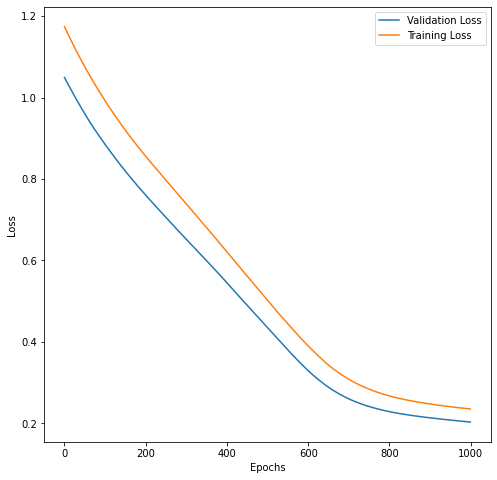

In [13]:
plot_loss(history)

# Task 7: Predictions

## 7.1: Plot Raw Predictions

Let's use the `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

8/8 [==============================] - 0s 3ms/step


C:\Users\HP\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


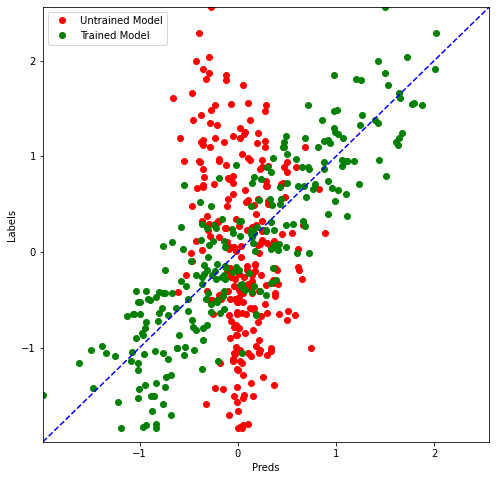

In [14]:
preds_on_trained = model.predict(X_test)

compare_predictions(preds_on_untrained, preds_on_trained, y_test)

# Here we get the normalised values of the price but we do not want this 

## 7.2: Plot Price Predictions

The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

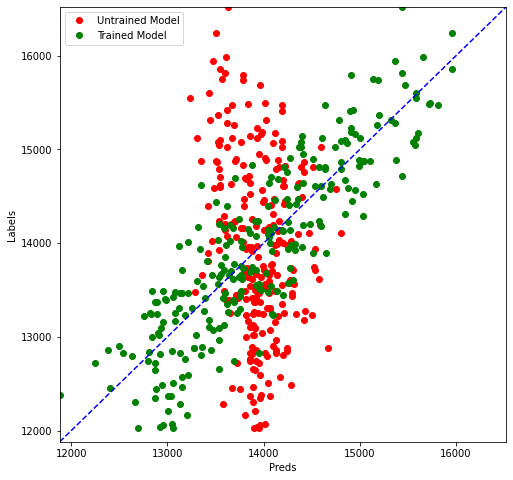

In [15]:
price_on_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_on_trained = [convert_label_value(y) for y in preds_on_trained]
price_y_test = [convert_label_value(y) for y in y_test]

compare_predictions(price_on_untrained, price_on_trained, price_y_test)

# Here we get the converted value from the normalised value of the price to the original value